#Mod of Midas to include

In [1]:
pip install timm

You should consider upgrading via the '/home/jovyan/dldiy/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7fd672823a90>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


Move model to GPU if available

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
()

()

In [4]:
for (name, layer) in midas._modules.items():
    #iteration over outer layers
    print((name))

pretrained
scratch


In [6]:
import os
import time
import csv
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.optim
cudnn.benchmark = True

from models import ResNet
from metrics import AverageMeter, Result
from dataloaders.dense_to_sparse import UniformSampling, SimulatedStereo,ORBSampling
import criteria
import utils
from dataloaders.nyu_dataloader import NYUDataset

In [8]:
train_dir=os.path.join('data', 'nyudepthv2', 'train')
test_dir=os.path.join('data', 'nyudepthv2', 'val')

sparsifier=UniformSampling(100,np.inf)
train_dataset = NYUDataset(train_dir, type='train', sparsifier=sparsifier,modality='rgbd')
val_dataset = NYUDataset(test_dir, type='val', sparsifier=sparsifier,modality='rgbd')
train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=10, shuffle=True,
            num_workers=1, pin_memory=True, sampler=None,
            worker_init_fn=lambda work_id:np.random.seed(work_id))
val_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=1, shuffle=False, num_workers=10, pin_memory=True)

Found 47584 images in train folder.
Found 654 images in val folder.


Load transforms to resize and normalize the image for large or small model

In [222]:
len(train_loader)

476

In [33]:
for i, (input, target) in enumerate(train_loader):
    print(input.shape)
    print(target.shape)
    break

torch.Size([10, 4, 228, 304])
torch.Size([10, 1, 228, 304])


tensor([0.3961, 0.2353, 0.2196])


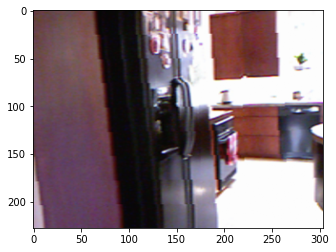

In [34]:
d=input[0,:3].permute(1,2,0)
plt.imshow(d)
#print(torch.nonzero(d).shape)
print(d[0,0])

In [35]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [36]:
print(np.shape(input[:1,:3].permute(0,2,3,1)*255))
input_batch=transform(np.array(input[0,:3].permute(1,2,0))*255)


torch.Size([1, 228, 304, 3])


In [33]:
input_batch.shape

torch.Size([1, 3, 288, 384])

array([13, 30, 12], dtype=uint8)

Predict and resize to original resolution

In [37]:
with torch.no_grad():
    prediction = midas(input_batch.cuda())

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=d.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

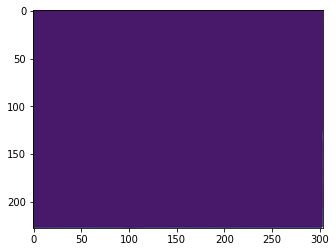

In [38]:
plt.imshow(output.squeeze())
# plt.show()

Let's try to modify the model to include partial depth informations

In [14]:
#First, let's fix the pretrained values :
for parameter in midas.parameters(): 
    parameter.requires_grad=False

In [12]:
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.md = midas
        self.fcomb = nn.Conv2d(2,1,(21,21),padding=(10,10),padding_mode='reflect')
        self.ReLU=nn.ReLU()
    def forward(self, x, y):
        x1 = self.md(x)
        x2 = self.fcomb(torch.cat((x1.unsqueeze(1),y),1))
        x3 = self.ReLU(x2)
        return x2


In [79]:
import random
x=input_batch
res=midas(input_batch.cuda())
y=torch.zeros_like(res)
lx,ly=res.shape[1],res.shape[2]
for _ in range(180):
  i,j=random.randint(0,lx-1),random.randint(0,ly-1)
  y[0,i,j]=res[0,i,j]
y=y.unsqueeze(1)

In [80]:
print(x.shape,y.shape)

torch.Size([1, 3, 288, 384]) torch.Size([1, 1, 288, 384])


In [86]:
model=MyModel()
model.to(device)
model.eval()
#res=model(x.cuda(),y.cuda())
()

()

In [13]:
from torchvision import transforms
def train( model, dataloader, loss, optimizer, n_epochs=1):
    model.train(True)
    i=torch.Tensor(0).cuda()
    for epoch in range(n_epochs):
        track_loss=[]
        for _, (input, ref) in enumerate(dataloader):
            x2=torch.zeros((np.shape(input)[0],3,288,384))
            for i in range(np.shape(x)[0]):
                x2[i]=transform(np.array(input[0,:3].permute(1,2,0))*255)
            y= transforms.Resize((288,384),antialias=True)(input[:,2:3])
            ref=transforms.Resize((288,384),antialias=True)(ref)
            res=model(x2.cuda(),y.cuda())
            l=loss(res,ref.cuda())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            track_loss.append(l.cpu())
            
            #print(f"[{(i+1)//10}] avg_loss : {sum(track_loss)/len(track_loss)}")
            if len(track_loss) % 1 == 0:
                print(f"[{(len(track_loss))//10}] avg_loss : {sum(track_loss[-min(len(track_loss),10):])/min(len(track_loss),10)}")
                #track_loss=[]
                #i=10
            i= i+1
    return mean


In [236]:
from torch.optim import SGD
from torch.nn import MSELoss
loss=MSELoss()
optimizer=SGD(model.parameters(),lr=10**-6)

In [237]:
train(model,train_loader,loss,optimizer)

RuntimeError: DataLoader worker (pid 39906) is killed by signal: Killed. 

In [38]:
print(x2.shape,y.shape)

torch.Size([10, 3, 288, 384]) torch.Size([10, 1, 288, 384])


In [152]:
with torch.no_grad():
    prediction2 = model(input_batch.cuda(),transforms.Resize((288,384),antialias=True)(input[:1,2:3]).cuda())

    prediction2 = torch.nn.functional.interpolate(
        prediction2,
        size=d.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


In [153]:
prediction2.shape

torch.Size([228, 304])

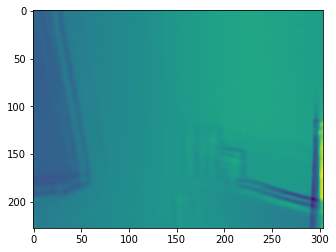

In [203]:
plt.imshow(prediction2.cpu())

In [159]:
with torch.no_grad():
    prediction = midas(input_batch.cuda())

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(0),
        size=d.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

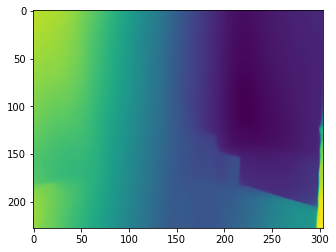

In [161]:
plt.imshow(output)

In [176]:
print(loss(prediction2.cpu(),transforms.Resize((228, 304),antialias=True)(target)[0,0]),loss(prediction.cpu(),-transforms.Resize((228, 304),antialias=True)(target)[0,0]))

tensor(21.8216) tensor(315.0498)


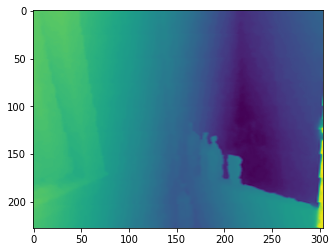

In [177]:
plt.imshow(-target[0,0])

In [195]:
print(sum(sum(prediction2)))
pred=prediction+torch.min(prediction)
pred2=prediction2+torch.min(prediction)
p1=pred/(sum(sum(pred))/(prediction.shape[0]*prediction.shape[1]))
p2=pred2/(sum(sum(pred2))/(p2.shape[0]*p2.shape[1]))
rf=transforms.Resize((228, 304),antialias=True)(target)[0,0]
rf=rf+torch.min(rf)
pr=rf/(sum(sum(rf))/(rf.shape[0]*rf.shape[1]))

tensor(208070.3594, device='cuda:0')


In [238]:
loss(p1.cpu(),rf.cpu()),loss(p2.cpu(),rf.cpu())

(tensor(1.5325), tensor(1.2650))

In [245]:
plt.imsave("p2opp.png", -p2.cpu())

In [52]:
#We try with ORB-samples now:

In [11]:
train_dir=os.path.join('data', 'nyudepthv2', 'train')
test_dir=os.path.join('data', 'nyudepthv2', 'val')

sparsifier=ORBSampling(100,np.inf)
train_dataset = NYUDataset(train_dir, type='train', sparsifier=sparsifier,modality='rgbd')
val_dataset = NYUDataset(test_dir, type='val', sparsifier=sparsifier,modality='rgbd')
train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=10, shuffle=True,
            num_workers=1, pin_memory=True, sampler=None,
            worker_init_fn=lambda work_id:np.random.seed(work_id))
val_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=1, shuffle=False, num_workers=10, pin_memory=True)

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

for parameter in midas.parameters(): 
    parameter.requires_grad=False

Found 47584 images in train folder.
Found 654 images in val folder.


Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


In [16]:
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.md = midas
        self.fcomb = nn.Conv2d(2,2,(21,21),padding=(10,10),padding_mode='reflect')
        self.f2 = nn.Conv2d(2,1,(21,21),padding=(10,10),padding_mode='reflect')
        self.ReLU=nn.ReLU()
    def forward(self, x, y):
        x1 = self.md(x)
        x2 = self.fcomb(torch.cat((x1.unsqueeze(1),y),1))
        x3 = self.ReLU(x2)
        x4 = self.f2(x3)
        return x4
model2=MyModel()
model2.to(device)
#model2.eval()
()

()

In [57]:
from torchvision import transforms
def train( model, dataloader, loss, optimizer, n_epochs=1):
    model.train(True)
    i=torch.Tensor(0).cuda()
    for epoch in range(n_epochs):
        track_loss=[]
        for _, (input, ref) in enumerate(dataloader):
            x2=torch.zeros((np.shape(input)[0],3,288,384))
            for i in range(np.shape(x2)[0]):
                x2[i]=transform(np.array(input[0,:3].permute(1,2,0))*255)
            y= transforms.Resize((288,384),antialias=True)(input[:,2:3])
            ref=transforms.Resize((288,384),antialias=True)(ref)
            #ref=torch.div(torch.ones_like(ref),ref)
            res=model(x2.cuda(),y.cuda())
            l=loss(res,ref.cuda())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            track_loss.append(l.cpu())
            
            #print(f"[{(i+1)//10}] avg_loss : {sum(track_loss)/len(track_loss)}")
            if len(track_loss) % 10 == 0:
                print(f"[{(len(track_loss))//10}] avg_loss : {sum(track_loss[-min(len(track_loss),10):])/min(len(track_loss),10)}")
                #track_loss=[]
                #i=10
            i= i+1
    return track_loss


In [18]:
from torch.optim import SGD
from torch.nn import MSELoss
loss=MSELoss()
optimizer=SGD(model2.parameters(),lr=8*10**-5)

In [58]:
%%time
losses=train(model2,train_loader,loss,optimizer,n_epochs=1)

[1] avg_loss : 2.4390358924865723
[2] avg_loss : 2.2168774604797363
[3] avg_loss : 2.492140293121338
[4] avg_loss : 2.0022501945495605
[5] avg_loss : 2.418515682220459
[6] avg_loss : 2.608656644821167
[7] avg_loss : 2.123291254043579
[8] avg_loss : 2.080256938934326
[9] avg_loss : 2.1303625106811523
[10] avg_loss : 1.933599829673767
[11] avg_loss : 2.336487293243408
[12] avg_loss : 2.075083017349243
[13] avg_loss : 2.1463639736175537
[14] avg_loss : 2.1182360649108887
[15] avg_loss : 1.9240598678588867
[16] avg_loss : 1.8985087871551514
[17] avg_loss : 1.8524011373519897
[18] avg_loss : 1.7406975030899048
[19] avg_loss : 1.9853578805923462
[20] avg_loss : 1.7216112613677979
[21] avg_loss : 2.1765494346618652
[22] avg_loss : 1.7304439544677734
[23] avg_loss : 1.7032802104949951
[24] avg_loss : 1.8410335779190063
[25] avg_loss : 2.136262893676758
[26] avg_loss : 1.8031749725341797
[27] avg_loss : 1.9967302083969116
[28] avg_loss : 1.6860634088516235
[29] avg_loss : 1.6248668432235718
[30

KeyboardInterrupt: 

In [98]:
def evaluate(model,test_loader):
    model.eval()
    eval_loss=[]
    for  _,(input, ref) in enumerate(test_loader):
        x2=torch.zeros((np.shape(input)[0],3,288,384))
        for i in range(np.shape(x2)[0]):
            x2[i]=transform(np.array(input[0,:3].permute(1,2,0))*255)
        y= transforms.Resize((288,384),antialias=True)(input[:,2:3])
        ref=transforms.Resize((288,384),antialias=True)(ref)
        res=model(x2.cuda(),y.cuda())
        l=loss(res,ref.cuda())
        eval_loss.append(l.cpu())
    return eval_loss

In [99]:
L=evaluate(model,val_loader)

RuntimeError: The expanded size of the tensor (384) must match the existing size (64) at non-singleton dimension 2.  Target sizes: [3, 288, 384].  Tensor sizes: [3, 384, 64]

In [21]:
#import dataloaders.dense_to_sparse as ds

In [88]:
import importlib
importlib.reload(ds)

<module 'dataloaders.dense_to_sparse' from '/home/jovyan/depth-CNN/dataloaders/dense_to_sparse.py'>

In [104]:
torch.save(model.state_dict(), "model")

In [43]:
for i, (input, target) in enumerate(train_loader):
    print(input.shape)
    print(target.shape)
    break
Xx=torch.zeros((10,3,288,384))
for i in range(10):
    Xx[i]= transform(np.array(input[i, :3].permute( 1, 2, 0))*255)
Yy= transforms.Resize((288,384),antialias=True)(input[:,2:3])


torch.Size([10, 4, 228, 304])
torch.Size([10, 1, 228, 304])


In [118]:
Xx[1,:].shape

torch.Size([3, 288, 384])

In [38]:
def save_midas( dataloader, address):
    start=[]
    for i, (input, ref) in enumerate(dataloader):
        x2=torch.zeros((np.shape(input)[0],3,288,384))
        for i in range(np.shape(x2)[0]):#batch_size=1
            x2[i]=transform(np.array(input[0,:3].permute(1,2,0))*255)
        y= transforms.Resize((288,384),antialias=True)(input[:,2:3])
        ref=transforms.Resize((288,384),antialias=True)(ref)
        #ref=torch.div(torch.ones_like(ref),ref)
        res=midas(x2.cuda())
        #print(res.shape,ref.shape,y.shape)
        Im=torch.zeros((3,288,384))
        Im[0]=res[0]
        Im[1]=ref[0,0]
        Im[2]=y[0,0]
        plt.imsave(address+'/pres'+str(len(start))+".png",(Im.detach().cpu().permute(1,2,0)*255).numpy().astype(np.uint8))
        start.append(len(start))
        if len(start)%30==1:
            print(f"{len(start)} / {len(dataloader)}")

In [ ]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=1, shuffle=True,
            num_workers=1, pin_memory=True, sampler=None,
            worker_init_fn=lambda work_id:np.random.seed(work_id))
save_midas(train_loader,"./data/preset")

1 / 47584
31 / 47584
61 / 47584
91 / 47584
121 / 47584
151 / 47584
181 / 47584
211 / 47584
241 / 47584
271 / 47584
301 / 47584
331 / 47584
361 / 47584
391 / 47584
421 / 47584
451 / 47584
481 / 47584
511 / 47584
541 / 47584
571 / 47584
601 / 47584
631 / 47584
661 / 47584
691 / 47584
721 / 47584
751 / 47584
781 / 47584
811 / 47584
841 / 47584
871 / 47584
901 / 47584
931 / 47584
961 / 47584
991 / 47584
1021 / 47584
1051 / 47584
1081 / 47584
1111 / 47584
1141 / 47584
1171 / 47584
1201 / 47584
1231 / 47584
1261 / 47584
1291 / 47584
1321 / 47584
1351 / 47584
1381 / 47584
1411 / 47584
1441 / 47584
1471 / 47584
1501 / 47584
1531 / 47584
1561 / 47584
1591 / 47584
1621 / 47584
1651 / 47584
1681 / 47584
1711 / 47584
1741 / 47584
1771 / 47584
1801 / 47584
1831 / 47584
1861 / 47584
1891 / 47584
1921 / 47584
1951 / 47584
1981 / 47584
2011 / 47584
2041 / 47584
2071 / 47584
2101 / 47584
2131 / 47584
2161 / 47584
2191 / 47584
2221 / 47584
2251 / 47584
2281 / 47584
2311 / 47584
2341 / 47584
2371 / 47584

In [32]:
from torch.utils.data import Dataset
import os
class Preset(Dataset):
    def __init__(self,path):
        self.files=os.listdir()
        self.__len__=len(self.files)
        self.idx=0
    def __get

'/home/jovyan/depth-CNN'

tensor(0.2411, grad_fn=<ToCopyBackward0>) tensor(271.7121, grad_fn=<ToCopyBackward0>)
tensor(0.7370, grad_fn=<ToCopyBackward0>) tensor(372.6573, grad_fn=<ToCopyBackward0>)
tensor(6.4226, grad_fn=<ToCopyBackward0>) tensor(293.3715, grad_fn=<ToCopyBackward0>)
tensor(1.2271, grad_fn=<ToCopyBackward0>) tensor(305.2012, grad_fn=<ToCopyBackward0>)
tensor(0.3227, grad_fn=<ToCopyBackward0>) tensor(581.0332, grad_fn=<ToCopyBackward0>)
tensor(0.4017, grad_fn=<ToCopyBackward0>) tensor(370.6254, grad_fn=<ToCopyBackward0>)
tensor(1.7455, grad_fn=<ToCopyBackward0>) tensor(413.2643, grad_fn=<ToCopyBackward0>)
tensor(3.6990, grad_fn=<ToCopyBackward0>) tensor(114.5419, grad_fn=<ToCopyBackward0>)
tensor(0.2725, grad_fn=<ToCopyBackward0>) tensor(136.1738, grad_fn=<ToCopyBackward0>)
tensor(1.9740, grad_fn=<ToCopyBackward0>) tensor(133.0255, grad_fn=<ToCopyBackward0>)


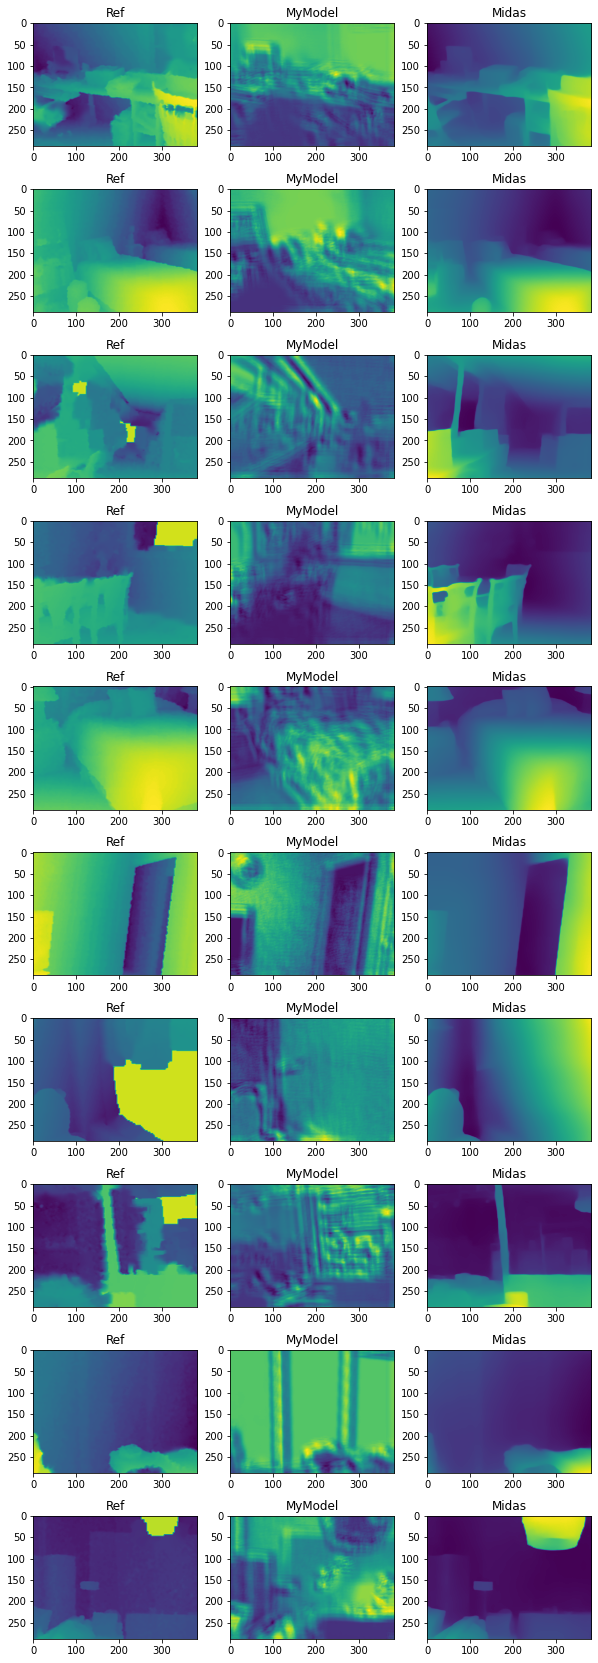

In [62]:
plt.figure(figsize=(10, 30))
model2.cuda()
midas.eval()
for i in range(10):
    x=Xx[i].unsqueeze(0)
    y=Yy[i].unsqueeze(0)
    ref=transforms.Resize((288,384),antialias=True)(target)[i,0]
    out1=model2(x.cuda(),y.cuda())
    out2=midas(x.cuda())
    print(loss(out1,ref.cuda()).cpu(),loss(out2,-ref.cuda()).cpu())
    plt.subplot(10, 3, i*3+1)
    plt.imshow(-ref)
    plt.title("Ref")
    plt.subplot(10, 3, i*3+2)
    plt.imshow(out1.detach().cpu()[0,0]+0.1)
    plt.title("MyModel")
    plt.subplot(10, 3, i*3+3)
    plt.imshow(out2.detach().cpu()[0])
    plt.title("Midas")
plt.show()

In [32]:
midas(x.cuda()*255)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3683],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [138]:
model.state_dict()['fcomb.weight']
()

()